# DLVC WS 2017

Tutorial 7: Stacked Denoising and Sparse Autoencoders
==

Load Packages
==

In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Load Data:
===============

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


Define the Sparse Autoencoder:
===============

In [4]:
class L1Penalty(Function):

    @staticmethod
    def forward(ctx, input, l1weight):
        ctx.save_for_backward(input)
        ctx.l1weight = l1weight
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_variables
        grad_input = input.clone().sign().mul(self.l1weight)
        grad_input += grad_output
        return grad_input

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Tanh(),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = L1Penalty.apply(x, 0.1)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

autoencoder (
  (encoder): Sequential (
    (0): Linear (784 -> 400)
    (1): Tanh ()
  )
  (decoder): Sequential (
    (0): Linear (400 -> 784)
    (1): Tanh ()
    (2): ReLU ()
  )
)


Train Autoencoder:
===========

In [6]:
iterations = 20
learning_rate = 1e-3
noise_mean = 0.1
noise_std = 0.2
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate) # Adam optimizer for optimization
for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            ideal_outputs = Variable(inputs.view(-1, 28*28).double()).cuda()
            noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double()).cuda()
            inputs = Variable(torch.clamp((ideal_outputs + noise).data,0,1).double()).cuda()
        else:
            ideal_outputs = Variable(inputs.view(-1, 28*28).double())
            noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double())
            inputs = Variable(torch.clamp((ideal_outputs + noise).data,0,1).double())

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, ideal_outputs) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data[0]
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
print('Finished Training')

At Iteration : 1 / 20  ;  Mean-Squared Error : 0.041360
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.015700
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.009962
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.007664
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.006520
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.005834
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.005385
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.005087
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.004869
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.004706
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.004579
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.004464
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.004387
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.004317
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.004255
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.004215
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.004155
At Iteration : 18 / 20  ;  Mean-Squared 

 Stacked Denoising and Sparse Autoencoder:
================================

In [7]:
# Adding New Layer (Stacking)
net.encoder.add_module('New_Encoder_Layer', nn.Sequential(nn.Linear(400, 256),nn.Tanh()))
net.encoder.add_module('New_Decoder_Layer', nn.Sequential(nn.Linear(256, 400),nn.Tanh()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

autoencoder (
  (encoder): Sequential (
    (0): Linear (784 -> 400)
    (1): Tanh ()
    (New_Encoder_Layer): Sequential (
      (0): Linear (400 -> 256)
      (1): Tanh ()
    )
    (New_Decoder_Layer): Sequential (
      (0): Linear (256 -> 400)
      (1): Tanh ()
    )
  )
  (decoder): Sequential (
    (0): Linear (400 -> 784)
    (1): Tanh ()
    (2): ReLU ()
  )
)


Train Autoencoder:
==========

In [8]:
for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        if use_gpu:
            ideal_outputs = Variable(inputs.view(-1, 28*28).double()).cuda()
            noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double()).cuda()
            inputs = Variable(torch.clamp((ideal_outputs + noise).data,0,1).double()).cuda()
        else:
            ideal_outputs = Variable(inputs.view(-1, 28*28).double())
            noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double())
            inputs = Variable(torch.clamp((ideal_outputs + noise).data,0,1).double())

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, ideal_outputs) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data[0]
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
print('Finished Training')

At Iteration : 1 / 20  ;  Mean-Squared Error : 0.036467
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.015230
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.011140
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.009267
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.008223
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.007520
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.007031
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.006653
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.006358
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.006123
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.005919
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.005748
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.005614
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.005490
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.005393
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.005297
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.005202
At Iteration : 18 / 20  ;  Mean-Squared 

Testing Autoencoder Performance:
=================

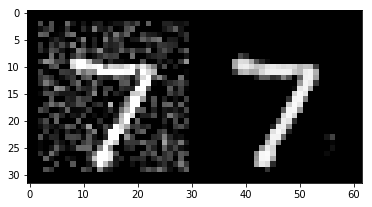

In [9]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

if use_gpu:
    ideal_outputs = Variable(images[0].view(-1,28*28).double()).cuda()
    noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double()).cuda()
    inputs = ideal_outputs + noise
    outImg = net(inputs).data
    outImg = outImg.view(-1,28,28).cpu()
else:
    ideal_outputs = Variable(images[0].view(-1,28*28).double())
    noise = Variable(ideal_outputs.data.new(ideal_outputs.size()).normal_(noise_mean, noise_std).double())
    inputs = ideal_outputs + noise
    outImg = net(inputs).data
    outImg = outImg.view(-1,28,28)

dispImg = torch.Tensor(2,1,28,28)
dispImg[0] = torch.clamp(inputs.data.view(-1,28,28).cpu(),0,1)
dispImg[1] = outImg

# show images
imshow(torchvision.utils.make_grid(dispImg))
